# IDC and RIDC Performance and Tests

We will calculate for the IDC method:

- Graph showing order of convergence for scalar and planar IVPs.
- Table showing order of convergence for above systems, using $M = 1, 2, 3$.
- Graph of runtime as $M$ is increased.

We will calculate for the RIDC method:

- Graph showing order of convergence for for scalar and planar IVPs.
- Table showing order of convergence for above systems, using $M = 1, 2, 3$.
- Choice of $K$ for $M = 1, 2, 3, 4$, impact on error and runtime.
- Impact of $K$ on stability region.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import pandas as pd

# import threading
import time
import numpy as np
from scipy.interpolate import lagrange

In [2]:
# IDC implementation with Euler's predictor and corrector:
def IDCsolver(ff, T, y0, N, M):
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of sub-intervals
    M:  number of correction loops

    Output:
    t: array of time points
    yy: approximations at the given time points
    '''
    
    # Number of invervals in each group
    if N % M != 0:
        raise "M must divide N evenly"
    
    J = int(N/M)
    
    # Time step
    h = float(T)/N
    
    # Number of equations in ODE (aka degree of freedom, dimension of space)
    d = len(y0)
    
    # Define the predictor and corrector functions
    def corrector_Euler(Yjm, Yjmm, TVal, Y1vec, Tvec, Sm):
        Yjmplus = Yjm+h*(ff(TVal, Yjm)-ff(TVal, Yjmm)) + \
            h*sum([Sm[i]*ff(Tvec[i], Y1vec[:, i]) for i in range(M+1)])
        return Yjmplus

    def predictor_Euler(Tjm, Yjm):
        return Yjm+h*ff(Tjm, Yjm)    
    
    # Forming the quadraure matrix S[m,i]
    S = np.zeros([M, M+1])
    for m in range(M):  # Calculate qudrature weights
        for i in range(M+1):
            x = np.arange(M+1)  # Construct a polynomial
            y = np.zeros(M+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(M+2)
            for k in range(M+1):
                P[k] = para[k]/(M+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    #Svec = S[M-1, :]
    
    # Storing the prediction and lower layer in ylow
    ylow = np.zeros([d, N+1])
    
    # Storing the final corrected answer in yy
    yy = np.zeros([d, N+1])
    
    # Time vector
    t = np.array([h*n for n in range(N+1)])
    
    # putting the initial condition in ylow and yy
    ylow[:, 0] = y0
    yy[:, 0] = y0
    
    for j in range(J):
        # Prediction loop
        for m in range(M):
            t[j*M+m] = (j*M+m)*h
            ylow[:, j*M+m+1] = predictor_Euler(t[j*M+m], ylow[:, j*M+m])
        
        # Correction loop
        for l in range(1,M+1):
            yy[:, j*M] = ylow[:, j*M]
            for m in range(M):
                yy[:, j*M+m+1] = corrector_Euler(yy[:, j*M+m],
                                                 ylow[:, j*M+m],
                                                 t[j*M+m],
                                                 ylow[:, j*M:j*M+M+1],
                                                 t[j*M:j*M+M+1],
                                                 S[m,:])
            ylow[:, j*M:j*M+M+1] = yy[:, j*M:j*M+M+1]
    
    return t, yy

In [3]:
'''
This code uses Tianming's scripts & RIDC algorithm (CHRISTLIEB et al. 2010)
This is a serial version and for simplicity the OOP are removed
Modified and personalised by Hossein Kafiabad
Tweaked slightly by Dylan Lyons
'''

# RIDC method with Euler's predictor and corrector
def RIDCsolver(ff, T, y0, N, M, K):
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M:  number of correction loops
    K:  length of grouped intervals for RIDC method, K > M

    Output:
    t: array of time points
    yy: approximations at the given time points
    '''
    # define the nested functions
    def corrector(Y2, Y1vec, Tvec):
        Y2plus = Y2+h*(ff(Tvec[-2], Y2)-ff(Tvec[-2], Y1vec[:, -2])) + \
            h*sum([Svec[i]*ff(Tvec[i], Y1vec[:, i]) for i in range(M+1)])
        return Y2plus

    def predictor(Ypred, Tpred):
        return Ypred+h*ff(Tpred, Ypred)
    
    # number of invervals in each group
    J = int(N/K)
    # time step
    h = float(T)/N
    # Forming the quadraure matrix S[m,i]
    # number of equations in ODE (aka degree of freedom, dimension of space)
    d = len(y0)
    S = np.zeros([M, M+1])
    for m in range(M):  # Calculate qudrature weights
        for i in range(M+1):
            x = np.arange(M+1)  # Construct a polynomial
            y = np.zeros(M+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(M+2)
            for k in range(M+1):
                P[k] = para[k]/(M+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[M-1, :]
    # storing the final answer in yy
    yy = np.zeros([d, N+1])
    # the time vector
    t = np.arange(0, T+h, h)
    t_ext = np.arange(0, T+h+M*h, h)
    # putting the initial condition in y
    yy[:, 0] = y0
    for j in range(J):   # loop over each group of intervals j
        
        # print(j) - ENABLE FOR TESTING!!!
        
        # ----------------------------------------------------------------------
        # Phase 1: compute to the point every threads can start simultaneously
        Ybegin = np.zeros([d, M+1, 2*M])
        # predictor starts w last point in j-1 interval
        Ybegin[:, 0, 0] = yy[:, j*K]
        # predictor loop using forward Euler method
        for m in range(2*M-1):
            t[j*K+m+1] = (j*K+m+1) * h
            Ybegin[:, 0, m+1] = Ybegin[:, 0, m]+h*ff(t[j*K+m], Ybegin[:, 0, m])
        # corrector loops using Lagrange polynomials
        for l in range(1, M+1):
            Ybegin[:, l, :] = np.zeros([d, 2*M])
            Ybegin[:, l, 0] = yy[:, j*K]
            for m in range(M):
                Ybegin[:, l, m+1] = Ybegin[:, l, m] + \
                    h*(ff(t[j*K+m], Ybegin[:, l, m])-ff(t[j*K+m], Ybegin[:, l-1, m])) + \
                    h*sum([S[m, i]*ff(t[j*K+i], Ybegin[:, l-1, i]) for i in range(M+1)])
            for m in range(M, 2*M-l):
                Ybegin[:, l, m+1] = Ybegin[:, l, m] + \
                    h*(ff(t[j*K+m], Ybegin[:, l, m])-ff(t[j*K+m], Ybegin[:, l-1, m])) + \
                    h*sum([S[M-1, i]*ff(t[j*K+m-M+i+1], Ybegin[:, l-1, m-M+i+1])
                           for i in range(M+1)])
        Ypred = Ybegin[:, 0, -1]
        yy[:, j*K:j*K+M] = Ybegin[:, M, 0:M]
        # declare and fill up Y1corr and Y2corr for phase two
        Y1corr = np.zeros([d, M, M+1])
        Y2corr = np.zeros([d, M])
        for l in range(1, M+1):
            # 'lm' is for corrector 'l' (trying to save space for Y1corr&Y2corr)
            lm = l - 1
            Y1corr[:, lm, :] = Ybegin[:, l-1, M-l:2*M-l+1]
            Y2corr[:, lm] = Ybegin[:, l, 2*M-l-1]
        # ----------------------------------------------------------------------
        # Phase 2: all threads can go simultaneously now
        for m in range(M-1, K):
            # predictor
            Tpred = t_ext[j*K+m+M]
            Ypred = predictor(Ypred, Tpred)
            # correctors
            for l in range(1, M+1):
                lm = l - 1
                Tvec = t_ext[j*K+m-l+1:j*K+m-l+1+M+1]
                Y2corr[:, lm] = corrector(Y2corr[:, lm], Y1corr[:, lm, :], Tvec)
            # update the stencil
            Y1corr[:, 0, 0:M] = Y1corr[:, 0, 1:M+1]
            Y1corr[:, 0, M] = Ypred
            for lm in range(1, M):
                Y1corr[:, lm, 0:M] = Y1corr[:, lm, 1:M+1]
                Y1corr[:, lm, M] = Y2corr[:, lm-1]
            # put the most corrected point in the final answer
            yy[:, j*K+m+1] = Y2corr[:, M-1]
    return t, yy

In [4]:
# Dalhquist test equation for lambda = 1
func_dahl = lambda t, y: y
exact_dahl = lambda t: np.exp(t)

# Scalar IVP
func_tsqrty = lambda t, y: 4*t*np.sqrt(y)
exact_tsqrty = lambda t: (1+t**2)**2

# Planar IVP
def func_sincos(t, y):
    y1 = y[0]
    y2 = y[1]
    y1_p = y2 - y1*(1-y1**2-y2**2)
    y2_p = -y1 + y2*(1-y1**2-y2**2)
    return np.array([y1_p, y2_p])

def exact_sincos(t):
    return np.array([np.sin(t), np.cos(t)])

# Returns time points vector for graphing
def get_tvec(T, N):
    h = float(T)/N
    return np.array([h*n for n in range(N+1)])

# Returns inf norm of a vector of exact and approx solution differences
def get_infnorm(approx, exact):
    D = exact.ndim
    if D == 1:
        return np.linalg.norm(approx-exact, np.inf)
    else:
        return max([np.linalg.norm(approx[i]-exact[i], np.inf) for i in range(len(exact))])


## IDC Method Tests (Chapter 3)

For IDC: Graph showing order of convergence for scalar IVP, using $M = 1, 2, 3$.

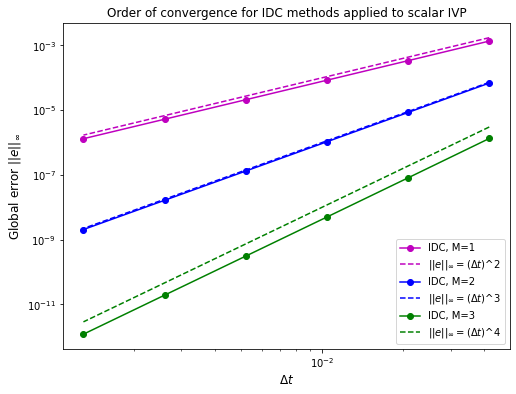

In [6]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,6)
#plt.rc('font', size=10)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10)

# Setting up parameters
T = 1.0
y0 = np.array([1.0])

# List of number of intervals
Ns = [24*2**i for i in np.arange(6)]

# Delta t values (step sizes)
delts = [T/n for n in Ns]

# Error vector inf norms for each step size when IDC is applied to scalar problem
cols = ['m', 'b', 'g', 'r', 'y', 'k', 'c']
for m in range(1,4):
    IDC_error_m = [get_infnorm(IDCsolver(func_tsqrty, T, y0, n, m)[1][0], 
                               exact_tsqrty(get_tvec(T, n))) for n in Ns]
    plt.plot(delts, IDC_error_m, cols[m-1]+'o-', label=f'IDC, M={m}')
    plt.plot(delts, [d**(m+1) for d in delts], cols[m-1]+'--', label=r'$\|\|e\|\|_{\infty} = (\Delta t)$'+f'^{m+1}')

plt.xscale('log')
plt.yscale('log')
plt.title(r'Order of convergence for IDC methods applied to scalar IVP')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'Global error $\|\|e\|\|_{\infty}$')
#plt.grid()
plt.legend(loc='lower right')
plt.show()

For IDC: Graph showing order of convergence for planar IVP, using $M = 1, 2, 3$.

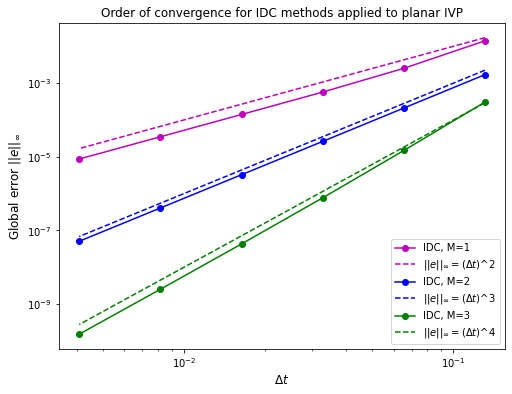

In [8]:
# Setting up parameters
T = np.pi
y0 = np.array([0.0, 1.0])

# List of number of intervals
Ns = [24*2**i for i in np.arange(6)]

# Delta t values (step sizes)
delts = [T/n for n in Ns]

# Error vector inf norms for each step size when IDC is applied to scalar problem
cols = ['m', 'b', 'g', 'r', 'y', 'k', 'c']
for m in range(1,4):
    IDC_error_m = [get_infnorm(IDCsolver(func_sincos, T, y0, n, m)[1], 
                               exact_sincos(get_tvec(T, n))) for n in Ns]
    plt.plot(delts, IDC_error_m, cols[m-1]+'o-', label=f'IDC, M={m}')
    plt.plot(delts, [d**(m+1) for d in delts], cols[m-1]+'--', label=r'$\|\|e\|\|_{\infty} = (\Delta t)$'+f'^{m+1}')

plt.xscale('log')
plt.yscale('log')
plt.title(r'Order of convergence for IDC methods applied to planar IVP')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'Global error $\|\|e\|\|_{\infty}$')
#plt.grid()
plt.legend(loc='lower right')
plt.show()

For IDC: Table showing order of convergence for scalar IVP, using $M = 1, 2, 3$.

In [13]:
# Setting up parameters
T = 1.0
y0 = np.array([1.0])

# List of number of intervals
Ns = [24*2**i for i in np.arange(6)]

# List of tables for each M value 
IDC_M_tables = []

for m in range(1,4):
    IDC_error_m = [get_infnorm(IDCsolver(func_tsqrty, T, y0, n, m)[1][0], 
                               exact_tsqrty(get_tvec(T, n))) for n in Ns]
    
    m_table = []
    for i, err in enumerate(IDC_error_m):
        if i == 0:
            m_table.append((r'$\Delta t$', err, "n/a"))
        else:
            order_val = np.log2(IDC_error_m[i-1]/err)
            m_table.append((r'$\Delta t$/'+f'{2**i}', err, np.round(order_val, 3)))
            
    IDC_M_tables.append(pd.DataFrame(m_table, columns=['Step Size', 'Max Error', 'Order']))
            
# Display results
print(f'For step size equal to 1/{Ns[0]}...')
for i, table in enumerate(IDC_M_tables):
    print(f'IDC method with M = {i+1}:')
    display(table)
    print()

For step size equal to 1/24...
IDC method with M = 1:


,Step Size,Max Error,Order
0,$\Delta t$,0.001363,n/a
1,$\Delta t$/2,0.000338,2.012
2,$\Delta t$/4,0.000084,2.006
3,$\Delta t$/8,0.000021,2.003
4,$\Delta t$/16,0.000005,2.001
5,$\Delta t$/32,0.000001,2.001



IDC method with M = 2:


,Step Size,Max Error,Order
0,$\Delta t$,6.863769e-05,n/a
1,$\Delta t$/2,8.486181e-06,3.016
2,$\Delta t$/4,1.054443e-06,3.009
3,$\Delta t$/8,1.313934e-07,3.005
4,$\Delta t$/16,1.639789e-08,3.002
5,$\Delta t$/32,2.048081e-09,3.001



IDC method with M = 3:


,Step Size,Max Error,Order
0,$\Delta t$,1.331397e-06,n/a
1,$\Delta t$/2,8.106083e-08,4.038
2,$\Delta t$/4,4.989437e-09,4.022
3,$\Delta t$/8,3.092819e-10,4.012
4,$\Delta t$/16,1.924594e-11,4.006
5,$\Delta t$/32,1.196376e-12,4.008


For IDC: Table showing order of convergence for planar IVP, using $M = 1, 2, 3$.

In [15]:
# Setting up parameters
T = np.pi
y0 = np.array([0.0, 1.0])

# List of number of intervals
Ns = [24*2**i for i in np.arange(6)]

# List of tables for each M value 
IDC_M_tables = []

for m in range(1,4):
    IDC_error_m = [get_infnorm(IDCsolver(func_sincos, T, y0, n, m)[1], 
                               exact_sincos(get_tvec(T, n))) for n in Ns]
    
    m_table = []
    for i, err in enumerate(IDC_error_m):
        if i == 0:
            m_table.append((r'$\Delta t$', err, "n/a"))
        else:
            order_val = np.log2(IDC_error_m[i-1]/err)
            m_table.append((r'$\Delta t$/'+f'{2**i}', err, np.round(order_val, 3)))
            
    IDC_M_tables.append(pd.DataFrame(m_table, columns=['Step Size', 'Max Error', 'Order']))
            
# Display results
print(f'For step size equal to pi/{Ns[0]}...')
for i, table in enumerate(IDC_M_tables):
    print(f'IDC method with M = {i+1}:')
    display(table)
    print()

For step size equal to pi/24...
IDC method with M = 1:


,Step Size,Max Error,Order
0,$\Delta t$,0.014115,n/a
1,$\Delta t$/2,0.002519,2.486
2,$\Delta t$/4,0.000572,2.14
3,$\Delta t$/8,0.000141,2.021
4,$\Delta t$/16,0.000035,2.011
5,$\Delta t$/32,0.000009,2.006



IDC method with M = 2:


,Step Size,Max Error,Order
0,$\Delta t$,1.702211e-03,n/a
1,$\Delta t$/2,2.104507e-04,3.016
2,$\Delta t$/4,2.616916e-05,3.008
3,$\Delta t$/8,3.263401e-06,3.003
4,$\Delta t$/16,4.074849e-07,3.002
5,$\Delta t$/32,5.091164e-08,3.001



IDC method with M = 3:


,Step Size,Max Error,Order
0,$\Delta t$,3.063575e-04,n/a
1,$\Delta t$/2,1.482276e-05,4.369
2,$\Delta t$/4,7.698164e-07,4.267
3,$\Delta t$/8,4.307598e-08,4.16
4,$\Delta t$/16,2.530425e-09,4.089
5,$\Delta t$/32,1.530708e-10,4.047


For IDC: Graph of runtime as $M$ is increased when applied to $y'(t) = y$.

In [10]:
# IDC method as above, but with controlled delay
def IDCsolver_with_delay(ff, T, y0, N, M, DT):
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of sub-intervals
    M:  number of correction loops
    DT: the number of delay loops applied to the prediction and correction functions

    Output:
    t: array of time points
    yy: approximations at the given time points
    '''
    
    # Number of invervals in each group
    if N % M != 0:
        raise "M must divide N evenly"
    
    J = int(N/M)
    
    # Time step
    h = float(T)/N
    
    # Number of equations in ODE (aka degree of freedom, dimension of space)
    d = len(y0)
    
    # Define the predictor and corrector functions
    def corrector_Euler(Yjm, Yjmm, TVal, Y1vec, Tvec, Sm):
        for i in range(DT):
            delay_var = Yjm+h*(ff(TVal, Yjm)-ff(TVal, Yjmm)) + \
            h*sum([Sm[i]*ff(Tvec[i], Y1vec[:, i]) for i in range(M+1)])
        Yjmplus = Yjm+h*(ff(TVal, Yjm)-ff(TVal, Yjmm)) + \
            h*sum([Sm[i]*ff(Tvec[i], Y1vec[:, i]) for i in range(M+1)])
        return Yjmplus

    def predictor_Euler(Tjm, Yjm):
        for i in range(DT):
            delay_var = Yjm+h*ff(Tjm, Yjm)
        return Yjm+h*ff(Tjm, Yjm)    
    
    # Forming the quadraure matrix S[m,i]
    S = np.zeros([M, M+1])
    for m in range(M):  # Calculate qudrature weights
        for i in range(M+1):
            x = np.arange(M+1)  # Construct a polynomial
            y = np.zeros(M+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(M+2)
            for k in range(M+1):
                P[k] = para[k]/(M+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    #Svec = S[M-1, :]
    
    # Storing the prediction and lower layer in ylow
    ylow = np.zeros([d, N+1])
    
    # Storing the final corrected answer in yy
    yy = np.zeros([d, N+1])
    
    # Time vector
    t = np.array([h*n for n in range(N+1)])
    
    # putting the initial condition in ylow and yy
    ylow[:, 0] = y0
    yy[:, 0] = y0
    
    for j in range(J):
        # Prediction loop
        for m in range(M):
            t[j*M+m] = (j*M+m)*h
            ylow[:, j*M+m+1] = predictor_Euler(t[j*M+m], ylow[:, j*M+m])
        
        # Correction loop
        for l in range(1,M+1):
            yy[:, j*M] = ylow[:, j*M]
            for m in range(M):
                yy[:, j*M+m+1] = corrector_Euler(yy[:, j*M+m],
                                                 ylow[:, j*M+m],
                                                 t[j*M+m],
                                                 ylow[:, j*M:j*M+M+1],
                                                 t[j*M:j*M+M+1],
                                                 S[m,:])
            ylow[:, j*M:j*M+M+1] = yy[:, j*M:j*M+M+1]
    
    return t, yy

In [11]:
# Setting up the parameters
T = 2.0
y0 = np.array([1.0])
N = 600
delays = 2

Ms = list(filter(lambda m: N % m == 0, np.arange(2, 16)))
Avg_runtimes = []
Avg_parallel = []

for M in Ms:
    print(f"M = {M}")
    runtimes = []
    for i in range(2):
        start = time.perf_counter()
        t, yy = IDCsolver_with_delay(func_dahl, T, y0, N, M, delays)
        finish = time.perf_counter()
        runtimes.append(finish-start)
    Avg_runtimes.append(np.mean(runtimes))
     
print("Done!")


M = 2
M = 3
M = 4
M = 5
M = 6
M = 8
M = 10
M = 12
M = 15
Done!


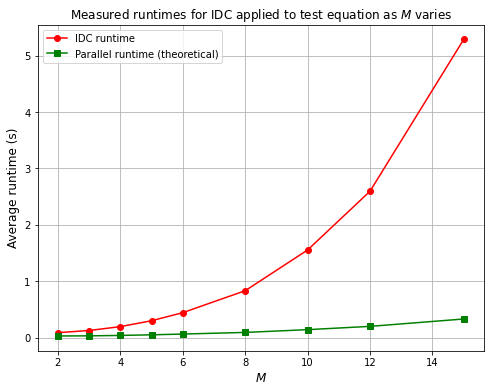

In [16]:
Avg_parallel = [Avg_runtimes[i]/(Ms[i]+1) for i in range(len(Ms))]
# Plotting results
plt.plot(Ms, Avg_runtimes, 'ro-', label=f'IDC runtime')
plt.plot(Ms, Avg_parallel, 'gs-', label=f'Parallel runtime (theoretical)')
plt.title(r'Measured runtimes for IDC applied to test equation as $M$ varies')
plt.xlabel(r'$M$')
plt.ylabel(r'Average runtime (s)')
plt.grid()
plt.legend(loc='upper left')
plt.show()

---

## RIDC-FE Method Tests (Chapter 4)

For RIDC: Graph showing order of convergence for scalar IVP, using $M = 1, 2, 3$ and $K = \frac{N}{3}$.

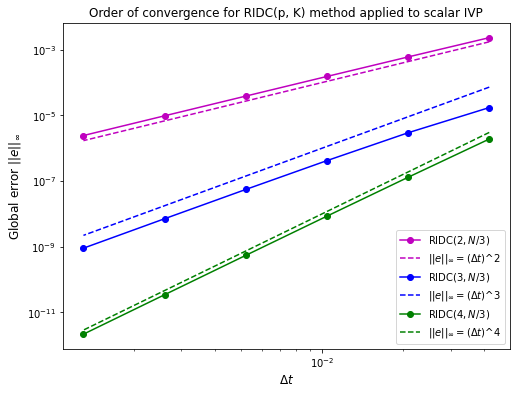

In [17]:
# Setting up the parameters...
T = 1.0
y0 = np.array([1.0])
# K = 8

# List of number of intervals
Ns = [24*2**i for i in np.arange(6)]

# Delta t values (step sizes)
delts = [T/n for n in Ns]

# Error vector inf norms for each step size when RIDC is applied
cols = ['m', 'b', 'g', 'r', 'y', 'k', 'c']
for m in range(1,4):
    RIDC_error_m = [get_infnorm(RIDCsolver(func_tsqrty, T, y0, n, m, int(n/3))[1][0], 
                                exact_tsqrty(get_tvec(T, n))) for n in Ns]
    plt.plot(delts, RIDC_error_m, cols[m-1]+'o-', label=f'RIDC({m+1}'+r'$,N/3)$')
    plt.plot(delts, [d**(m+1) for d in delts], cols[m-1]+'--', label=r'$\|\|e\|\|_{\infty} = (\Delta t)$'+f'^{m+1}')

plt.xscale('log')
plt.yscale('log')
plt.title(r'Order of convergence for RIDC(p, K) method applied to scalar IVP')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'Global error $\|\|e\|\|_{\infty}$')
#plt.grid()
plt.legend(loc='lower right')
plt.show()

For RIDC: Table showing order of convergence for scalar IVP, using $M = 1, 2, 3$ and $K = \frac{N}{3}$.

In [18]:
# Setting up the parameters...
T = 1.0
y0 = np.array([1.0])
# K = 8

# List of number of intervals
Ns = [24*2**i for i in np.arange(6)]

# List of tables for each M value 
RIDC_M_tables = []

for m in range(1,4):
    RIDC_error_m = [get_infnorm(RIDCsolver(func_tsqrty, T, y0, n, m, int(n/3))[1][0], 
                                exact_tsqrty(get_tvec(T, n))) for n in Ns]
    
    m_table = []
    for i, err in enumerate(RIDC_error_m):
        if i == 0:
            m_table.append((r'$\Delta t$', err, "n/a"))
        else:
            order_val = np.log2(RIDC_error_m[i-1]/err)
            m_table.append((r'$\Delta t$/'+f'{2**i}', err, np.round(order_val, 3)))
            
    RIDC_M_tables.append(pd.DataFrame(m_table, columns=['Step Size', 'Max Error', 'Order']))
            
# Display results
print(f'For step size equal to 1/{Ns[0]}...')
for i, table in enumerate(RIDC_M_tables):
    print(f'RIDC method with M = {i+1}:')
    display(table)
    print()
    

For step size equal to 1/24...
RIDC method with M = 1:


,Step Size,Max Error,Order
0,$\Delta t$,0.002324,n/a
1,$\Delta t$/2,0.000601,1.951
2,$\Delta t$/4,0.000153,1.975
3,$\Delta t$/8,0.000039,1.987
4,$\Delta t$/16,0.000010,1.994
5,$\Delta t$/32,0.000002,1.997



RIDC method with M = 2:


,Step Size,Max Error,Order
0,$\Delta t$,1.723421e-05,n/a
1,$\Delta t$/2,2.946961e-06,2.548
2,$\Delta t$/4,4.173690e-07,2.82
3,$\Delta t$/8,5.521410e-08,2.918
4,$\Delta t$/16,7.091345e-09,2.961
5,$\Delta t$/32,8.982333e-10,2.981



RIDC method with M = 3:


,Step Size,Max Error,Order
0,$\Delta t$,1.896184e-06,n/a
1,$\Delta t$/2,1.297744e-07,3.869
2,$\Delta t$/4,8.489739e-09,3.934
3,$\Delta t$/8,5.428924e-10,3.967
4,$\Delta t$/16,3.431877e-11,3.984
5,$\Delta t$/32,2.155609e-12,3.993


For RIDC: Graph showing order of convergence for planar IVP, using $M = 1, 2, 3$ and $K = \frac{N}{3}$.

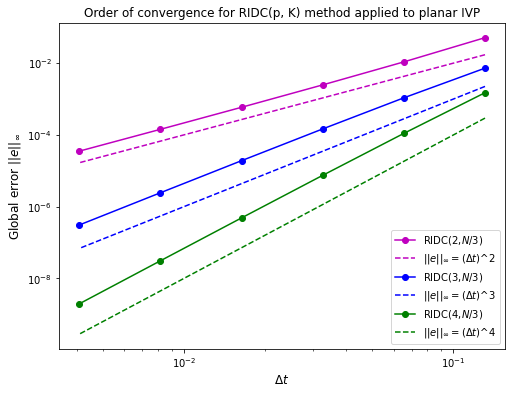

In [18]:
# Setting up parameters
T = np.pi
y0 = np.array([0.0, 1.0])
# K = 8

# List of number of intervals
Ns = [24*2**i for i in np.arange(6)]

# Delta t values (step sizes)
delts = [T/n for n in Ns]

# Error vector inf norms for each step size when RIDC is applied
cols = ['m', 'b', 'g', 'r', 'y', 'k', 'c']
for m in range(1,4):
    RIDC_error_m = [get_infnorm(RIDCsolver(func_sincos, T, y0, n, m, int(n/3))[1], 
                                exact_sincos(get_tvec(T, n))) for n in Ns]
    plt.plot(delts, RIDC_error_m, cols[m-1]+'o-', label=f'RIDC({m+1},'+r'$N/3)$')
    plt.plot(delts, [d**(m+1) for d in delts], cols[m-1]+'--', label=r'$\|\|e\|\|_{\infty} = (\Delta t)$'+f'^{m+1}')

plt.xscale('log')
plt.yscale('log')
plt.title(r'Order of convergence for RIDC(p, K) method applied to planar IVP')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'Global error $\|\|e\|\|_{\infty}$')
#plt.grid()
plt.legend(loc='lower right')
plt.show()

For RIDC: Table showing order of convergence for planar system, using $M = 1, 2, 3$ and $K = \frac{N}{3}$.

In [21]:
# Setting up parameters
T = np.pi
y0 = np.array([0.0, 1.0])
# K = 8

# List of number of intervals
Ns = [24*2**i for i in np.arange(6)]

# List of tables for each M value 
RIDC_M_tables = []

for m in range(1,4):
    RIDC_error_m = [get_infnorm(RIDCsolver(func_sincos, T, y0, n, m, int(n/3))[1], 
                                exact_sincos(get_tvec(T, n))) for n in Ns]
    
    m_table = []
    for i, err in enumerate(RIDC_error_m):
        if i == 0:
            m_table.append((r'$\Delta t$', err, "n/a"))
        else:
            order_val = np.log2(RIDC_error_m[i-1]/err)
            m_table.append((r'$\Delta t$/'+f'{2**i}', err, np.round(order_val, 3)))
            
    RIDC_M_tables.append(pd.DataFrame(m_table, columns=['Step Size', 'Max Error', 'Order']))
            
# Display results
print(f'For step size equal to pi/{Ns[0]}...')
for i, table in enumerate(RIDC_M_tables):
    print(f'RIDC method with M = {i+1}:')
    display(table)
    print()
    

For step size equal to pi/24...
RIDC method with M = 1:


,Step Size,Max Error,Order
0,$\Delta t$,0.051196,n/a
1,$\Delta t$/2,0.010824,2.242
2,$\Delta t$/4,0.002474,2.129
3,$\Delta t$/8,0.000588,2.074
4,$\Delta t$/16,0.000143,2.04
5,$\Delta t$/32,0.000035,2.021



RIDC method with M = 2:


,Step Size,Max Error,Order
0,$\Delta t$,7.243004e-03,n/a
1,$\Delta t$/2,1.079284e-03,2.747
2,$\Delta t$/4,1.466469e-04,2.88
3,$\Delta t$/8,1.910839e-05,2.94
4,$\Delta t$/16,2.438498e-06,2.97
5,$\Delta t$/32,3.079834e-07,2.985



RIDC method with M = 3:


,Step Size,Max Error,Order
0,$\Delta t$,1.498330e-03,n/a
1,$\Delta t$/2,1.101769e-04,3.765
2,$\Delta t$/4,7.466652e-06,3.883
3,$\Delta t$/8,4.861181e-07,3.941
4,$\Delta t$/16,3.101391e-08,3.97
5,$\Delta t$/32,1.958492e-09,3.985


For RIDC: Choice of $K$, impact on error and runtime

In [19]:
# Setting up the parameters...
T = 1.0
y0 = np.array([1.0])
N = 1200

# Generate list of suitable K values (with regards to the N divisibility condition)
Ks = list(filter(lambda n: N % n == 0, np.arange(8,601)))

# List of tables for each M value 
RIDC_MK_tables = []

for m in range(1,5):
    mk_table = []
    
    for k in Ks:
        start = time.perf_counter()
        t, yy = RIDCsolver(func_tsqrty, T, y0, N, m, k)
        finish = time.perf_counter()
        RIDC_error_m = get_infnorm(yy[0], exact_tsqrty(t))
        mk_table.append((k, RIDC_error_m, np.round(finish-start, 3)))
        
    RIDC_MK_tables.append(pd.DataFrame(mk_table, columns=['K', 'Max Error', 'Runtime']))

# Display results
for i, table in enumerate(RIDC_MK_tables):
    print(f'RIDC method with M = {i+1}:')
    display(table.head())
    print()
    

RIDC method with M = 1:


,K,Max Error,Runtime
0,8,5.453407e-07,0.061
1,10,5.478089e-07,0.061
2,12,5.502753e-07,0.049
3,15,5.539712e-07,0.053
4,16,5.552022e-07,0.051



RIDC method with M = 2:


,K,Max Error,Runtime
0,8,2.222031e-10,0.118
1,10,2.489862e-10,0.105
2,12,2.675784e-10,0.103
3,15,2.865104e-10,0.103
4,16,2.912808e-10,0.105



RIDC method with M = 3:


,K,Max Error,Runtime
0,8,2.113865e-13,0.185
1,10,2.189360e-13,0.188
2,12,2.096101e-13,0.177
3,15,2.153833e-13,0.176
4,16,2.087219e-13,0.169



RIDC method with M = 4:


,K,Max Error,Runtime
0,8,3.108624e-14,0.314
1,10,3.419487e-14,0.300
2,12,3.597123e-14,0.290
3,15,3.730349e-14,0.279
4,16,3.863576e-14,0.266


The K axis with logarithmic scaling:




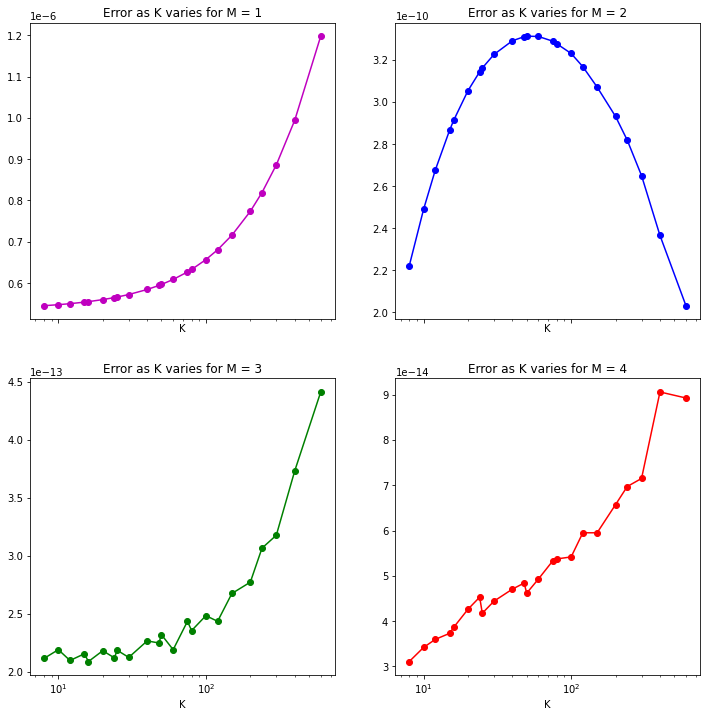

In [33]:
fig, axes = plt.subplots(figsize=(12,12), ncols=2, nrows=2, sharex=True)

print(f"The K axis with logarithmic scaling:\n\n")

for i, ax in enumerate(axes):
    for j, ax_ in enumerate(ax):
        m_m1 = 2*i + j
        table = RIDC_MK_tables[m_m1]
        ax_.plot(list(table['K']), list(table['Max Error']), cols[m_m1]+'o-')
        ax_.set_xscale('log')
        ax_.set_title(f'Error as K varies for M = {m_m1+1}')
        ax_.set_xlabel("K")
        #ax_.set_ylabel("Global Error")
    


The K axis with logarithmic scaling:




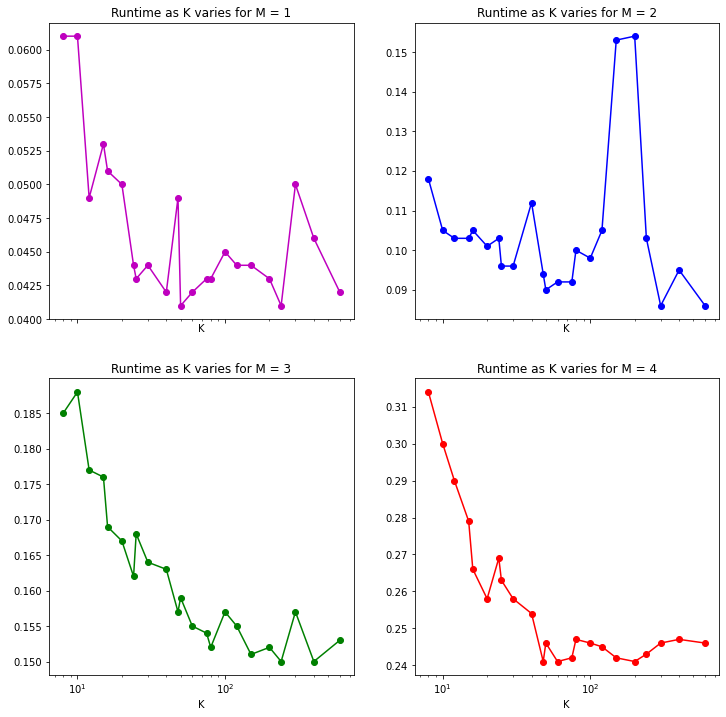

In [34]:
fig, axes = plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharex=True)

print(f"The K axis with logarithmic scaling:\n\n")

for i, ax in enumerate(axes):
    for j, ax_ in enumerate(ax):
        m_m1 = 2*i + j
        #print(m_m1)
        table = RIDC_MK_tables[m_m1]
        ax_.plot(list(table['K']), list(table['Runtime']), cols[m_m1]+'o-')
        ax_.set_xscale('log')
        ax_.set_title(f'Runtime as K varies for M = {m_m1+1}')
        ax_.set_xlabel("K")
        #ax_.set_ylabel("Runtime")
    


For RIDC: numerically approximating the stability region using Dalhquist's Test Equation.

In [20]:
# Dalhquist test equation for lambda
lam = complex(0, 0)
func_dahl_lam = lambda t, y: lam*y
exact_dahl_lam = lambda t: np.exp(lam*t)

# Forwards Euler method with Dalhquist eqn support
def ForwardsEuler_complex(f, T, y0, N):
    '''
    Inputs:
    f:  the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of time intervals

    Output:
    y:  as function of time
    '''
    
    # time step
    h = float(T)/N
    
    # time points vector
    t = np.arange(0, T+h, h)
    
    # output vector
    y = np.zeros(N+1)
    
    # setting initial condition
    if type(y0) == complex:
        y = np.array([complex(0, 0) for y_ in y])
        
    y[0] = y0
    
    # Forwards Euler method
    for i in range(N):
        y[i+1] = y[i] + h*f(t[i], y[i])
    
    return y, h, t 

# RIDC Solver using Euler pred and corr with Dahlquist eqn support
def RIDCsolver_complex(ff, T, y0, N, M, K):
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M:  number of correction loops
    K:  length of grouped intervals for RIDC method, K > M

    Output:
    t: array of time points
    yy: approximations at the given time points
    '''
    # define the nested functions
    def corrector(Y2, Y1vec, Tvec):
        Y2plus = Y2+h*(ff(Tvec[-2], Y2)-ff(Tvec[-2], Y1vec[:, -2])) + \
            h*sum([Svec[i]*ff(Tvec[i], Y1vec[:, i]) for i in range(M+1)])
        return Y2plus

    def predictor(Ypred, Tpred):
        return Ypred+h*ff(Tpred, Ypred)
    
    # number of invervals in each group
    J = int(N/K)
    # time step
    h = float(T)/N
    # Forming the quadraure matrix S[m,i]
    # number of equations in ODE (aka degree of freedom, dimension of space)
    if type(y0) == complex:
        d = 1
    else:
        d = len(y0)
    S = np.zeros([M, M+1])
    for m in range(M):  # Calculate qudrature weights
        for i in range(M+1):
            x = np.arange(M+1)  # Construct a polynomial
            y = np.zeros(M+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(M+2)
            for k in range(M+1):
                P[k] = para[k]/(M+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[M-1, :]
    # storing the final answer in yy
    yy = np.zeros([d, N+1])
    
    # complex support:
    if type(y0) == complex:
        yy = np.array([[complex(0, 0) for i_ in np.arange(N+1)]])
    
    # the time vector
    t = np.arange(0, T+h, h)
    t_ext = np.arange(0, T+h+M*h, h)
    # putting the initial condition in y
    yy[:, 0] = y0
    for j in range(J):   # loop over each group of intervals j
        
        # print(j) - ENABLE FOR TESTING!!!
        
        # ----------------------------------------------------------------------
        # Phase 1: compute to the point every threads can start simultaneously
        Ybegin = np.zeros([d, M+1, 2*M])
        if type(y0) == complex:
            Ybegin = np.array([[[complex(0, 0) for i_ in np.arange(2*M)] for j_ in np.arange(M+1)]])
        # predictor starts w last point in j-1 interval
        Ybegin[:, 0, 0] = yy[:, j*K]
        # predictor loop using forward Euler method
        for m in range(2*M-1):
            t[j*K+m+1] = (j*K+m+1) * h
            Ybegin[:, 0, m+1] = Ybegin[:, 0, m]+h*ff(t[j*K+m], Ybegin[:, 0, m])
        # corrector loops using Lagrange polynomials
        for l in range(1, M+1):
            Ybegin[:, l, :] = np.zeros([d, 2*M])
            if type(y0) == complex:
                Ybegin[:, l, :] = np.array([[complex(0, 0) for i_ in np.arange(2*M)]])
            Ybegin[:, l, 0] = yy[:, j*K]
            for m in range(M):
                Ybegin[:, l, m+1] = Ybegin[:, l, m] + \
                    h*(ff(t[j*K+m], Ybegin[:, l, m])-ff(t[j*K+m], Ybegin[:, l-1, m])) + \
                    h*sum([S[m, i]*ff(t[j*K+i], Ybegin[:, l-1, i]) for i in range(M+1)])
            for m in range(M, 2*M-l):
                Ybegin[:, l, m+1] = Ybegin[:, l, m] + \
                    h*(ff(t[j*K+m], Ybegin[:, l, m])-ff(t[j*K+m], Ybegin[:, l-1, m])) + \
                    h*sum([S[M-1, i]*ff(t[j*K+m-M+i+1], Ybegin[:, l-1, m-M+i+1])
                           for i in range(M+1)])
        Ypred = Ybegin[:, 0, -1]
        yy[:, j*K:j*K+M] = Ybegin[:, M, 0:M]
        # declare and fill up Y1corr and Y2corr for phase two
        Y1corr = np.zeros([d, M, M+1])
        if type(y0) == complex:
            Y1corr = np.array([[[complex(0, 0) for i_ in np.arange(M+1)] for j_ in np.arange(M)]])
        Y2corr = np.zeros([d, M])
        if type(y0) == complex:
            Y2corr = np.array([[complex(0, 0) for i_ in np.arange(M)]])
        for l in range(1, M+1):
            # 'lm' is for corrector 'l' (trying to save space for Y1corr&Y2corr)
            lm = l - 1
            Y1corr[:, lm, :] = Ybegin[:, l-1, M-l:2*M-l+1]
            Y2corr[:, lm] = Ybegin[:, l, 2*M-l-1]
        # ----------------------------------------------------------------------
        # Phase 2: all threads can go simultaneously now
        for m in range(M-1, K):
            # predictor
            Tpred = t_ext[j*K+m+M]
            Ypred = predictor(Ypred, Tpred)
            # correctors
            for l in range(1, M+1):
                lm = l - 1
                Tvec = t_ext[j*K+m-l+1:j*K+m-l+1+M+1]
                Y2corr[:, lm] = corrector(Y2corr[:, lm], Y1corr[:, lm, :], Tvec)
            # update the stencil
            Y1corr[:, 0, 0:M] = Y1corr[:, 0, 1:M+1]
            Y1corr[:, 0, M] = Ypred
            for lm in range(1, M):
                Y1corr[:, lm, 0:M] = Y1corr[:, lm, 1:M+1]
                Y1corr[:, lm, M] = Y2corr[:, lm-1]
            # put the most corrected point in the final answer
            yy[:, j*K+m+1] = Y2corr[:, M-1]
    return t, yy

We numerically approximate the stability region of RIDC with fixed order $M = 3$ and variety of appropriate $K$ values when applied to Dalhquist's test equation. Time interval is divided into $N = 60$ sub-intervals. Euler's method stability region is included as a comparison.

In [21]:
# Setting up parameters...
M = 3
# final time
T = 60
# number of intervals
N = 60
# initial condition y(0) = y0
y0 = complex(1, 0)
# new centre at (-1, 0)
cen = complex(-1, 0)

# Setting up parameters
thetas = np.linspace(0, 2*np.pi, 161)
INC = 7
base = 2**(-INC)
eps = 1

# Setting up additional parameters
M = 3
#Ks = [20, 30]
Ks = [6, 10, 15, 20, 30, 60]

RIDC_K_bound = []

for k in Ks:
    print(f"K = {k}")
    K_bound = []
    for theta in thetas:
        Aact = 0
        Acurr = 1
        count = 0
        searching = True
        
        while searching:
            Acurr = base*2**count
            if Acurr > 4:
                break
            A = Aact + Acurr
            lam = complex(A*np.cos(theta), A*np.sin(theta)) + cen
            last_val = RIDCsolver_complex(func_dahl_lam, T, y0, N, M, k)[1][:, -1]
            inf_norm = np.abs(last_val)
            
            if inf_norm > eps:
                count = 0
                if Acurr > base:
                    Aact += Acurr/2
                else:
                    searching = False
            else:
                count += 1
        
        
        if Acurr <= 4:
            K_bound.append([lam.real, lam.imag])
            
    RIDC_K_bound.append(np.array(K_bound))
    
print("Done!")

K = 6
K = 10
K = 15
K = 20
K = 30
K = 60
Done!


In [22]:
# Boundary values of Euler's method region of abs stability
euler_bound = []

for theta in thetas:
    lam_ = complex(np.cos(theta), np.sin(theta)) + cen
    euler_bound.append([lam_.real, lam_.imag])
        
euler_bound = np.array(euler_bound)

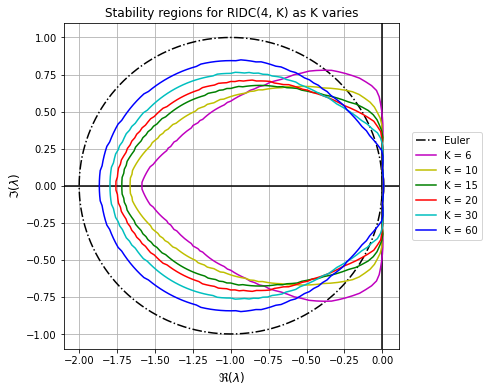

In [37]:
# Plotting results
cols = ['m', 'y', 'g', 'r', 'c', 'b', 'k']

plt.figure(figsize = (6, 6))
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10)

plt.plot(euler_bound[:, 0], euler_bound[:, 1], 'k-.', label='Euler')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

for i, k_bound in enumerate(RIDC_K_bound):
    plt.plot(k_bound[:, 0], k_bound[:, 1], cols[i], label=f'K = {Ks[i]}')

plt.title(r'Stability regions for RIDC(4, K) as K varies')
plt.xlabel(r'$\Re(\lambda)$')
plt.ylabel(r'$\Im(\lambda)$')
plt.grid()
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()